In [31]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import re
import nltk
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import pos_tag # 词性
from nltk.tokenize import word_tokenize # 分词
from nltk.corpus import stopwords # 停用词
from nltk.stem import PorterStemmer, WordNetLemmatizer # 词干化，词态统一
from tqdm import tqdm  # 显示处理进度
tqdm.pandas(desc="Processing excerpts")



lemmatizer = WordNetLemmatizer()
#Different sources of stopwords
nltk_stopwords = set(stopwords.words('english')) 
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
wordcloud_stopwords = set(STOPWORDS)
with open('.\\dictionaries\\expandedstopwords.txt', 'r') as file:
    txt_stopwords = [line.strip() for line in file.readlines()]
    
stopwords_df = pd.DataFrame({'Words': txt_stopwords})
additional_stopwords = set(stopwords_df.to_numpy().flatten())

In [2]:
# 清洗文本数据
def clean_text(text):
    # 去除数字、特殊符号和标点符号
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 去除多余空格和换行符
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # 转换为小写
    cleaned_text = cleaned_text.lower()
    return cleaned_text

# 分词和词形还原
def tokenize_and_lemmatize(text):
    tqdm.pandas(desc="Tokenizing")
    # 分词
    words = nltk.word_tokenize(text)
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# 去停用词
def remove_stopwords(tokens):
    stop_words = sklearn_stopwords.union(additional_stopwords, wordcloud_stopwords, nltk_stopwords)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# 词干化
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # 添加进度条
    return stemmed_tokens

In [3]:
def preprocess_text(text):
    # 基本处理
    cleaned_text = clean_text(text)
    # 分词和词形还原
    lemmatized_tokens = tokenize_and_lemmatize(cleaned_text)
    # 去停用词
    non_stop_words = remove_stopwords(lemmatized_tokens)
    
    return non_stop_words

###  Load dataset

1. Load original dataset(first time)

In [22]:
filepath = './Dataset/bloomberg_news.csv'
df = pd.read_csv(filepath)
df = df.drop(df.columns[0], axis=1)
df.rename(columns={'0':'times', '1':'articles'}, inplace=True)
print(df)

             times                                           articles
0       2006-10-20  -- Inco's Net Soars on Higher Metal Prices, Br...
1       2006-10-21  -- Jim Cramer: Diageo, Anheuser-Busch, Monster...
2       2006-10-23  -- EU Energy Chief Backs German Plan for Price...
3       2006-10-23  -- Ex-Plant Worker Shuster Pleads Guilty in Tr...
4       2006-10-24  -- Jim Cramer: Bare Escentuals, Allergan, Medi...
...            ...                                                ...
448390  2013-11-26  -- Rubber Drops to Two-Week Low After Forecast...
448391  2013-11-26  -- SNB’s Jordan Sees No Reason to Remove Cap o...
448392  2013-11-26  -- U.K. Lawmakers Seek ‘Sharp’ Change as Bank ...
448393  2013-11-26  -- UBS Offers to Repurchase Some Shares of Pue...
448394  2013-11-26  -- Hyundai Motor Unveils New Genesis to Boost ...

[448395 rows x 2 columns]


In [5]:
df['articles'].fillna('', inplace=True) 

In [6]:
df['articles'].values[0]

"-- Inco's Net Soars on Higher Metal Prices, Breakup Fee\n-- Dale Crofts\n-- 2006-10-20T20:16:16Z\n-- http://www.bloomberg.com/news/2006-10-20/inco-s-net-soars-on-higher-metal-prices-breakup-fee-update4-.html\n\n          \n          \n             Inco Ltd., the Canadian nickel producer\nbeing bought by  Brazil 's Cia. Vale do Rio, said third-quarter\nprofit soared 11-fold, boosted by surging metal prices and fees\npaid by Falconbridge Ltd. after a failed takeover.  \n Net income jumped to $701 million, or $3.08 a share, from $64\nmillion, or 29 cents, a year earlier, Toronto-based Inco said today\nin a statement. Results included $109 million in net fees from the\nfailed deals with Falconbridge and Phelps Dodge Corp. Sales jumped\nto $2.32 billion from $1.08 billion.  \n Inco sold nickel at double the price last year on average, and\noutput jumped 13 percent. Demand for the metal, used in stainless\nsteel, surged as global economic growth fueled demand, especially\nin  China . Mines 

In [7]:
clean = clean_text(df['articles'].values[0])
clean

' incos net soars on higher metal prices breakup fee dale crofts tz httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml inco ltd the canadian nickel producer being bought by brazil s cia vale do rio said thirdquarter profit soared fold boosted by surging metal prices and fees paid by falconbridge ltd after a failed takeover net income jumped to million or a share from million or cents a year earlier torontobased inco said today in a statement results included million in net fees from the failed deals with falconbridge and phelps dodge corp sales jumped to billion from billion inco sold nickel at double the price last year on average and output jumped percent demand for the metal used in stainless steel surged as global economic growth fueled demand especially in china mines have failed to keep pace prompting a buying spree by producers seeking to bolster ore deposits vale outbid phelps dodge and teck cominco ltd with its billion bid record quarterly earnings ref

In [8]:
tl = tokenize_and_lemmatize(clean)
tl

['incos',
 'net',
 'soar',
 'on',
 'higher',
 'metal',
 'price',
 'breakup',
 'fee',
 'dale',
 'croft',
 'tz',
 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml',
 'inco',
 'ltd',
 'the',
 'canadian',
 'nickel',
 'producer',
 'being',
 'bought',
 'by',
 'brazil',
 's',
 'cia',
 'vale',
 'do',
 'rio',
 'said',
 'thirdquarter',
 'profit',
 'soared',
 'fold',
 'boosted',
 'by',
 'surging',
 'metal',
 'price',
 'and',
 'fee',
 'paid',
 'by',
 'falconbridge',
 'ltd',
 'after',
 'a',
 'failed',
 'takeover',
 'net',
 'income',
 'jumped',
 'to',
 'million',
 'or',
 'a',
 'share',
 'from',
 'million',
 'or',
 'cent',
 'a',
 'year',
 'earlier',
 'torontobased',
 'inco',
 'said',
 'today',
 'in',
 'a',
 'statement',
 'result',
 'included',
 'million',
 'in',
 'net',
 'fee',
 'from',
 'the',
 'failed',
 'deal',
 'with',
 'falconbridge',
 'and',
 'phelps',
 'dodge',
 'corp',
 'sale',
 'jumped',
 'to',
 'billion',
 'from',
 'billion',
 'inco',
 'sold',
 'nickel',
 'at',
 

In [9]:
rm = remove_stopwords(tl)
rm

['incos',
 'net',
 'soar',
 'metal',
 'price',
 'breakup',
 'fee',
 'dale',
 'croft',
 'tz',
 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml',
 'inco',
 'canadian',
 'nickel',
 'producer',
 'bought',
 'brazil',
 'cia',
 'vale',
 'rio',
 'thirdquarter',
 'profit',
 'soared',
 'fold',
 'boosted',
 'surging',
 'metal',
 'price',
 'fee',
 'paid',
 'falconbridge',
 'failed',
 'takeover',
 'net',
 'income',
 'jumped',
 'share',
 'cent',
 'earlier',
 'torontobased',
 'inco',
 'statement',
 'result',
 'net',
 'fee',
 'failed',
 'deal',
 'falconbridge',
 'phelps',
 'dodge',
 'corp',
 'sale',
 'jumped',
 'billion',
 'billion',
 'inco',
 'sold',
 'nickel',
 'double',
 'price',
 'average',
 'output',
 'jumped',
 'percent',
 'demand',
 'metal',
 'stainless',
 'steel',
 'surged',
 'global',
 'economic',
 'growth',
 'fueled',
 'demand',
 'china',
 'failed',
 'pace',
 'prompting',
 'buying',
 'spree',
 'producer',
 'seeking',
 'bolster',
 'ore',
 'deposit',
 'vale',
 'out

In [10]:
print(preprocess_text(df['articles'].values[0]))

['incos', 'net', 'soar', 'metal', 'price', 'breakup', 'fee', 'dale', 'croft', 'tz', 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml', 'inco', 'canadian', 'nickel', 'producer', 'bought', 'brazil', 'cia', 'vale', 'rio', 'thirdquarter', 'profit', 'soared', 'fold', 'boosted', 'surging', 'metal', 'price', 'fee', 'paid', 'falconbridge', 'failed', 'takeover', 'net', 'income', 'jumped', 'share', 'cent', 'earlier', 'torontobased', 'inco', 'statement', 'result', 'net', 'fee', 'failed', 'deal', 'falconbridge', 'phelps', 'dodge', 'corp', 'sale', 'jumped', 'billion', 'billion', 'inco', 'sold', 'nickel', 'double', 'price', 'average', 'output', 'jumped', 'percent', 'demand', 'metal', 'stainless', 'steel', 'surged', 'global', 'economic', 'growth', 'fueled', 'demand', 'china', 'failed', 'pace', 'prompting', 'buying', 'spree', 'producer', 'seeking', 'bolster', 'ore', 'deposit', 'vale', 'outbid', 'phelps', 'dodge', 'teck', 'cominco', 'billion', 'bid', 'record', 'quarterly', '

In [11]:
from tqdm import tqdm

# 使用 tqdm 显示处理进度
tqdm.pandas()

# 对 DataFrame 中的 'articles' 列应用 preprocess_text 函数
df['processed_articles'] = df['articles'].progress_apply(preprocess_text)


100%|█████████████████████████████████████████████████████████████████████████| 448395/448395 [20:39<00:00, 361.72it/s]


In [12]:
df.to_json('./Dataset/bloomberg_news_processed.json', orient='records')

2. Load processed datset

In [4]:
df = pd.read_json('./Dataset/bloomberg_news_processed.json')
df

,times,articles,processed_articles
0,2006-10-20,"-- Inco's Net Soars on Higher Metal Prices, Br...","[incos, net, soar, metal, price, breakup, fee,..."
1,2006-10-21,"-- Jim Cramer: Diageo, Anheuser-Busch, Monster...","[jim, cramer, diageo, anheuserbusch, monster, ..."
2,2006-10-23,-- EU Energy Chief Backs German Plan for Price...,"[eu, energy, chief, german, plan, price, contr..."
3,2006-10-23,-- Ex-Plant Worker Shuster Pleads Guilty in Tr...,"[explant, worker, shuster, pleads, guilty, tra..."
4,2006-10-24,"-- Jim Cramer: Bare Escentuals, Allergan, Medi...","[jim, cramer, bare, escentuals, allergan, medi..."
...,...,...,...
448390,2013-11-26,-- Rubber Drops to Two-Week Low After Forecast...,"[rubber, drop, twoweek, forecast, surplus, wid..."
448391,2013-11-26,-- SNB’s Jordan Sees No Reason to Remove Cap o...,"[snbs, jordan, reason, remove, cap, swiss, fra..."
448392,2013-11-26,-- U.K. Lawmakers Seek ‘Sharp’ Change as Bank ...,"[uk, lawmaker, seek, sharp, change, bank, lord..."
448393,2013-11-26,-- UBS Offers to Repurchase Some Shares of Pue...,"[ubs, offer, repurchase, share, puerto, rico, ..."


In [5]:
df['year'] = pd.to_datetime(df['times']).dt.year
df = df.drop('articles', axis=1)

In [9]:
df['processed_articles'].values[0]

['incos',
 'net',
 'soar',
 'metal',
 'price',
 'breakup',
 'fee',
 'dale',
 'croft',
 'tz',
 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml',
 'inco',
 'canadian',
 'nickel',
 'producer',
 'bought',
 'brazil',
 'cia',
 'vale',
 'rio',
 'thirdquarter',
 'profit',
 'soared',
 'fold',
 'boosted',
 'surging',
 'metal',
 'price',
 'fee',
 'paid',
 'falconbridge',
 'failed',
 'takeover',
 'net',
 'income',
 'jumped',
 'share',
 'cent',
 'earlier',
 'torontobased',
 'inco',
 'statement',
 'result',
 'net',
 'fee',
 'failed',
 'deal',
 'falconbridge',
 'phelps',
 'dodge',
 'corp',
 'sale',
 'jumped',
 'billion',
 'billion',
 'inco',
 'sold',
 'nickel',
 'double',
 'price',
 'average',
 'output',
 'jumped',
 'percent',
 'demand',
 'metal',
 'stainless',
 'steel',
 'surged',
 'global',
 'economic',
 'growth',
 'fueled',
 'demand',
 'china',
 'failed',
 'pace',
 'prompting',
 'buying',
 'spree',
 'producer',
 'seeking',
 'bolster',
 'ore',
 'deposit',
 'vale',
 'out

###  Load dictionaries

In [10]:
# 从txt文件读取词汇
with open('.\\dictionaries\\unionOfDicts.txt', 'r') as file:
    txt_data = [line.strip() for line in file.readlines()]

with open('.\\dictionaries\\ubaltFin.txt', 'r') as file:
    ubaltFin_data = [line.strip() for line in file.readlines()]
    
# 创建包含文本文件中词汇的DataFrame
txt_df = pd.DataFrame({'Word': txt_data})
ubaltFin_df = pd.DataFrame({'Word': ubaltFin_data})  

# 合并两个DataFrame
lm_dict = pd.concat([txt_df, ubaltFin_df], ignore_index=True)

# 显示合并后的DataFrame
print(lm_dict)

                      Word
0           hyperinflation
1               fiat money
2            law economics
3          creditor nation
4           mortgage terms
...                    ...
16975  balance account zba
16976      zerocoupon bond
16977               profit
16978         substitution
16979             sum game

[16980 rows x 1 columns]


In [11]:
# 将词典索引小写化
lm_dict['Word'] = lm_dict['Word'].str.lower()

- 查看articles中所含有的词典单词数量

In [16]:
# 函数来计算每一行列表中有多少词在词典中
def count_words_in_dictionary(row):
    words_in_row = set(row)
    words_in_dictionary = words_in_row.intersection(lm_dict['Word'])
    return len(words_in_dictionary)

# 应用函数到特定列，并创建一个新列来存储词典中的词的数量
wordcount = df['processed_articles'].apply(count_words_in_dictionary)
print(wordcount)

0         29
1         16
2         20
3          7
4         14
          ..
448390    10
448391    23
448392    15
448393    17
448394    16
Name: processed_articles, Length: 448395, dtype: int64


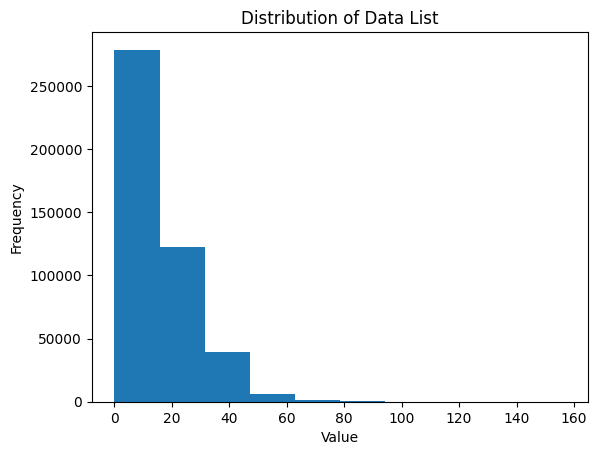

In [17]:
import matplotlib.pyplot as plt

plt.hist(wordcount, bins=10)  # bins代表直方图的柱数，可根据需要调整
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data List')
plt.show()

In [12]:
# 函数来计算每一行列表中有哪些词在词典中
def words_in_dictionary(row):
    words_in_row = set(row)
    words_in_dictionary = words_in_row.intersection(lm_dict['Word'])
    return words_in_dictionary

# 应用函数到特定列，并创建一个新列来存储词典中的词的数量
word_dict = df['processed_articles'].apply(words_in_dictionary)
print(word_dict)

0         {shareholder, bid, exchange, growth, income, m...
1         {positive, technology, stock, takeover, quarte...
2         {government, investment, country, export, comp...
3         {news, stock, learning, smith, parent, david, ...
4         {good, life, competition, investment, technolo...
                                ...                        
448390    {demand, surplus, expected, exchange, growth, ...
448391    {overheating, exchange, inflation, capital, cu...
448392    {demand, james, service, change, rule, bankrup...
448393    {life, record, investment, yield, data, limit,...
448394    {record, country, investment, technology, opti...
Name: processed_articles, Length: 448395, dtype: object


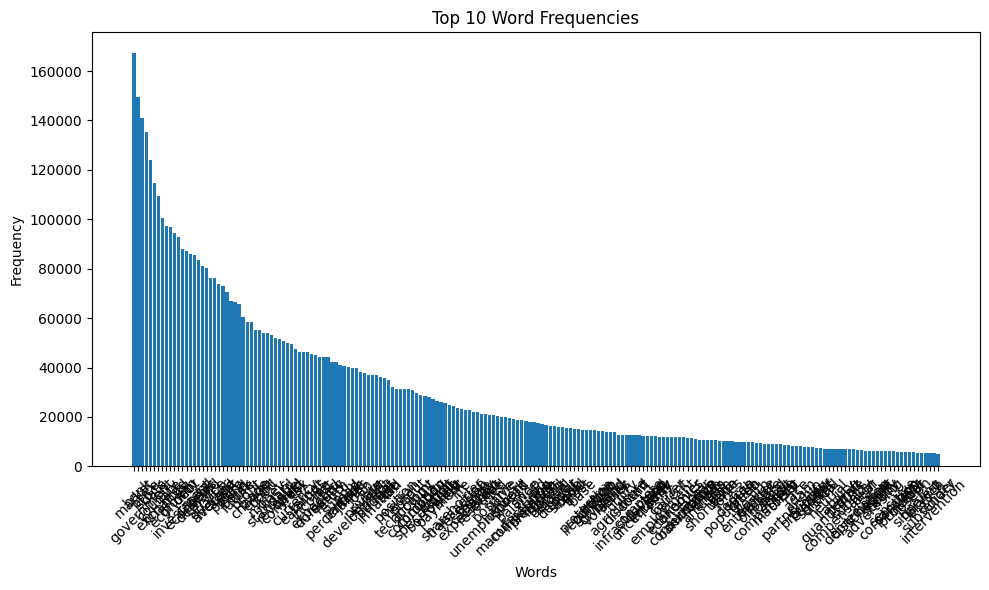

In [13]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# 假设您的数据存储在名为 df 的 DataFrame 中的 'words_set' 列中
# 将所有集合合并
all_words = [word for words_set in word_dict for word in words_set]

# 统计词频
word_counts = Counter(all_words)

# 选择最常见的词语及其出现次数
top_words = word_counts.most_common(200)  # 这里选择出现频率最高的前10个词

# 将词频可视化为条形图
words, frequencies = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
from collections import Counter

# 将 Counter 对象转换为字典，然后转换为 DataFrame
word_counts_dict = dict(word_counts)
df_wc = pd.DataFrame(list(word_counts_dict.items()), columns=['Word', 'Frequency'])

# 获取 DataFrame 的描述性统计信息
description = df_wc.describe()
print(description)


           Frequency
count     688.000000
mean     9571.488372
std     21479.838089
min         1.000000
25%       108.000000
50%       847.500000
75%      7181.000000
max    167310.000000


In [15]:
df_wc

,Word,Frequency
0,shareholder,24544
1,bid,32141
2,exchange,100618
3,growth,92969
4,income,45469
...,...,...
683,autarky,4
684,queueing,2
685,ecu,2
686,customs,4


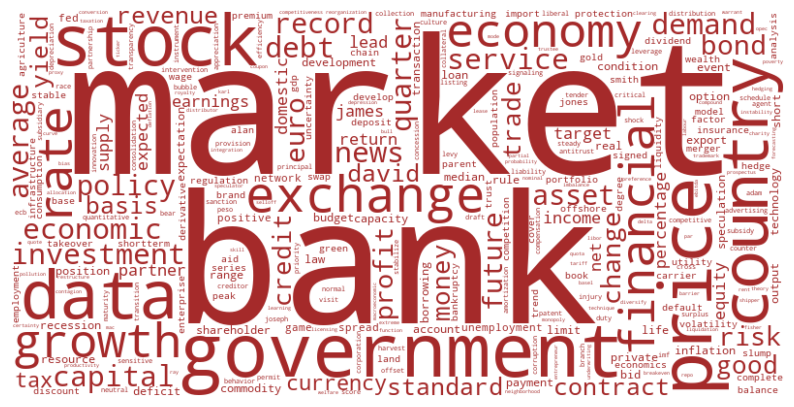

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 假设您有一个名为 word_freq 的字典，包含词语和对应的词频
# word_freq = {'word1': 10, 'word2': 8, 'word3': 5, ...}

# 创建 WordCloud 对象
wordcloud = WordCloud(width=800, height=400, max_words=300, background_color='white', color_func=lambda *args, **kwargs: "brown").generate_from_frequencies(word_counts_dict)

# 显示词云图像
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 隐藏坐标轴
plt.show()


In [17]:
#Forming a new dictionary based on financial words from the articles
financial_dictionary = list(word_counts_dict.keys())

In [20]:
len(financial_dictionary)

688

In [19]:
import json
file_path = './dictionaries/financial_dictionary.json'

with open(file_path, 'w') as json_file:
    json.dump(financial_dictionary, json_file, indent=4)


TF-IDF

In [21]:
df['processed_articles'] = df['processed_articles'].apply(lambda x: ' '.join(x))

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# 创建TfidfVectorizer对象，并使用术语每天出现的文章数代替整个语料库的文章数
def tfidf_per_day(docs):
    tfidf_vectorizer = TfidfVectorizer(vocabulary=financial_dictionary, smooth_idf=True)
    tfidf_data = tfidf_vectorizer.fit_transform(docs)
    # 将 TF-IDF 结果转换为 DataFrame
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=financial_dictionary)
    return tfidf_df

# 按日期分组，计算每天出现的文章数
grouped = df.groupby('times')['processed_articles'].apply(lambda x: ' '.join(x))
term_frequency_per_day = tfidf_per_day(grouped)


In [23]:
print(term_frequency_per_day)

      shareholder       bid  exchange    growth    income    merger    demand  \
0        0.083682  0.166633  0.149351  0.077667  0.080861  0.092831  0.308852   
1        0.000000  0.000000  0.000000  0.131021  0.000000  0.000000  0.000000   
2        0.000000  0.000000  0.000000  0.000000  0.000000  0.067412  0.000000   
3        0.000000  0.168992  0.050488  0.105023  0.054670  0.000000  0.261021   
4        0.242263  0.000000  0.036031  0.000000  0.234095  0.089583  0.037256   
...           ...       ...       ...       ...       ...       ...       ...   
1939     0.045434  0.065546  0.124942  0.103270  0.025087  0.009257  0.098388   
1940     0.024487  0.036570  0.076480  0.068181  0.000000  0.000000  0.101673   
1941     0.009650  0.044835  0.091852  0.071649  0.027973  0.000000  0.065294   
1942     0.046587  0.053442  0.104836  0.104336  0.036209  0.005617  0.098119   
1943     0.000000  0.016646  0.119358  0.162934  0.024233  0.009274  0.092561   

       country    output   

In [24]:
#Add times to TF-IDF
times_df = df.groupby('times')['times'].first().reset_index(drop=True)
result_df = pd.concat([term_frequency_per_day, times_df], axis=1)

In [25]:
from datetime import datetime

# 将时间戳转换为季度时间
def convert_to_quarter(timestamp):
    date = datetime.strptime(timestamp, "%Y-%m-%d")
    quarter_year = date.year
    #找到对应季度的月份起始日期
    if(date.month >= 1 and date.month < 4 ):
        quarter_start =  4 
    elif(date.month >= 4 and date.month < 7 ):
        quarter_start =  7 
    elif(date.month >= 7 and date.month < 10 ):
        quarter_start =  10 
    else:
        quarter_year = date.year + 1
        quarter_start =  1 
    quarter_date = datetime(quarter_year, quarter_start, 1)
    return quarter_date.strftime("%Y-%m-%d")  # 返回季度时间

result_df['times_quarter'] = result_df['times'].apply(convert_to_quarter)

In [26]:
print(result_df)

      shareholder       bid  exchange    growth    income    merger    demand  \
0        0.083682  0.166633  0.149351  0.077667  0.080861  0.092831  0.308852   
1        0.000000  0.000000  0.000000  0.131021  0.000000  0.000000  0.000000   
2        0.000000  0.000000  0.000000  0.000000  0.000000  0.067412  0.000000   
3        0.000000  0.168992  0.050488  0.105023  0.054670  0.000000  0.261021   
4        0.242263  0.000000  0.036031  0.000000  0.234095  0.089583  0.037256   
...           ...       ...       ...       ...       ...       ...       ...   
1939     0.045434  0.065546  0.124942  0.103270  0.025087  0.009257  0.098388   
1940     0.024487  0.036570  0.076480  0.068181  0.000000  0.000000  0.101673   
1941     0.009650  0.044835  0.091852  0.071649  0.027973  0.000000  0.065294   
1942     0.046587  0.053442  0.104836  0.104336  0.036209  0.005617  0.098119   
1943     0.000000  0.016646  0.119358  0.162934  0.024233  0.009274  0.092561   

       country    output   

### Predictive indicators

GDP

In [27]:
gdp = pd.read_csv('./Predictive indicators/Processed_GDP.csv')
gdp

,Unnamed: 0,observation_date,GDPC1,InflationCoeff,inflation_GDP,GDP Growth Rate,CAGR,CAGR2
0,56,1961-01-01,3493.703,1.014580,3443.497631,-0.007717,-0.020950,0.600648
1,57,1961-04-01,3553.021,1.014580,3501.963217,0.016979,-0.004327,0.627824
2,58,1961-07-01,3621.252,1.014580,3569.213721,0.019204,0.014794,0.659084
3,59,1961-10-01,3692.289,1.014580,3639.229902,0.019617,0.034701,0.691630
4,60,1962-01-01,3758.147,1.025443,3664.900531,0.007054,0.020784,0.312175
...,...,...,...,...,...,...,...,...
243,299,2021-10-01,21847.602,8.878599,2460.703711,0.016968,-0.005839,0.038485
244,300,2022-01-01,21738.871,9.295703,2338.593476,-0.049624,-0.006561,0.037769
245,301,2022-04-01,21708.160,9.295703,2335.289692,-0.001413,-0.006583,0.037745
246,302,2022-07-01,21851.134,9.295703,2350.670346,0.006586,-0.006478,0.037855


In [28]:
gdp[['observation_date', 'CAGR2']]

,observation_date,CAGR2
0,1961-01-01,0.600648
1,1961-04-01,0.627824
2,1961-07-01,0.659084
3,1961-10-01,0.691630
4,1962-01-01,0.312175
...,...,...
243,2021-10-01,0.038485
244,2022-01-01,0.037769
245,2022-04-01,0.037745
246,2022-07-01,0.037855


In [51]:
predictive_gdp = gdp[(gdp['observation_date'] >= '2007-01-01') & (gdp['observation_date'] <= '2014-01-01')]
len(predictive_gdp)

In [29]:
quarter_sizes = result_df.groupby('times_quarter').size()
print(quarter_sizes)

times_quarter
2007-01-01    46
2007-04-01    60
2007-07-01    58
2007-10-01    58
2008-01-01    55
2008-04-01    59
2008-07-01    33
2008-10-01    11
2009-01-01    26
2009-04-01    39
2009-07-01    45
2009-10-01    36
2010-01-01    54
2010-04-01    75
2010-07-01    63
2010-10-01    85
2011-01-01    92
2011-04-01    83
2011-07-01    91
2011-10-01    92
2012-01-01    87
2012-04-01    91
2012-07-01    91
2012-10-01    92
2013-01-01    92
2013-04-01    90
2013-07-01    91
2013-10-01    92
2014-01-01    57
dtype: int64


In [33]:
def concatenate_vectors(group):
    vectors_to_concatenate = group.iloc[:, :-2].values  # 选择要拼接的列，倒数第二列之前的所有列
    concatenated_matrix = np.vstack(vectors_to_concatenate)  # 按行拼接，如果是列拼接则使用 np.hstack
    return concatenated_matrix

# 按'times_quarter'分组并应用拼接函数
grouped_matrices = result_df.groupby('times_quarter').apply(concatenate_vectors)

# 打印每个分组的矩阵
for group_name, matrix in grouped_matrices.items():
    print(f"Times Quarter: {group_name}")
    print(matrix)  # 这里的 matrix 是每个分组的拼接后的矩阵


Times Quarter: 2007-01-01
[[0.08368201 0.16663259 0.14935058 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.32450222 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Times Quarter: 2007-04-01
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.0697191  ... 0.         0.         0.        ]
 [0.29197844 0.29070243 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.10725064 ... 0.         0.         0.        ]
 [0.08529843 0.05661711 0.10149032 ... 0.         0.         0.        ]
 [0.         0.         0.04872963 ... 0.         0.         0.        ]]
Times Quarter: 2007-07-01
[[0.         0.         0.10959955

In [54]:
from sklearn.decomposition import TruncatedSVD

# 这里假设grouped_matrices是你已经分组后的矩阵列表

# 创建LSA模型
lsa_model = TruncatedSVD(n_components= 10)

V_matrices = []
for matrix in grouped_matrices:
    # 对每个分组的矩阵执行LSA奇异值分解
    lsa_model.fit(matrix)
    V_matrices.append(lsa_model.components_)

# V_matrices中包含了每个分组的V矩阵


In [71]:
reshaped_data.shape

(29, 6880)

In [70]:
reshaped_data = np.vstack([arr.reshape(1, -1) for arr in V_matrices])

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# 定义模型列表
models = [
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(),
    MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
]

X = reshaped_data
y = predictive_gdp['CAGR2']  # 目标值

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for model in models:
    # 获取模型名称
    model_name = model.__class__.__name__
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 评估模型性能
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"{model_name} Training R^2 Score: {train_score:.2f}")
    print(f"{model_name} Testing R^2 Score: {test_score:.2f}")
    print("-----------------------")


LinearRegression Training R^2 Score: 1.00
LinearRegression Testing R^2 Score: -0.01
-----------------------
SVR Training R^2 Score: -0.00
SVR Testing R^2 Score: -0.47
-----------------------
DecisionTreeRegressor Training R^2 Score: 1.00
DecisionTreeRegressor Testing R^2 Score: 0.36
-----------------------
RandomForestRegressor Training R^2 Score: 0.96
RandomForestRegressor Testing R^2 Score: 0.63
-----------------------
GradientBoostingRegressor Training R^2 Score: 1.00
GradientBoostingRegressor Testing R^2 Score: 0.64
-----------------------
MLPRegressor Training R^2 Score: -289.58
MLPRegressor Testing R^2 Score: -6350.82
-----------------------


In [86]:
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # 获取模型的预测值
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"{model_name} Training Predictions:")
    print(y_pred_train)  # 输出训练集的预测值
    print("Actual Values:")
    print(y_train.values)  # 输出训练集的实际值
    print("-----------------------")
    
    print(f"{model_name} Testing Predictions:")
    print(y_pred_test)  # 输出测试集的预测值
    print("Actual Values:")
    print(y_test.values)  # 输出测试集的实际值
    print("-----------------------")


LinearRegression Training Predictions:
[0.04159034 0.0418595  0.04214925 0.04111128 0.04426338 0.04348956
 0.04361863 0.04439101 0.04023916 0.04453018 0.04083213 0.04029162
 0.04110673 0.0397947  0.04069106 0.04302307 0.04192062 0.04175037
 0.04133473 0.04350413]
Actual Values:
[0.04159034 0.0418595  0.04214925 0.04111128 0.04426338 0.04348956
 0.04361863 0.04439101 0.04023916 0.04453018 0.04083213 0.04029162
 0.04110673 0.0397947  0.04069106 0.04302307 0.04192062 0.04175037
 0.04133473 0.04350413]
-----------------------
LinearRegression Testing Predictions:
[0.04138632 0.04214044 0.04236555 0.04174655 0.04238232 0.04209118
 0.04207698 0.04248214 0.04182344]
Actual Values:
[0.04062844 0.04097364 0.04138976 0.040809   0.0418841  0.04184608
 0.04078019 0.04412788 0.04045804]
-----------------------
SVR Training Predictions:
[0.04216244 0.04216244 0.04216244 0.04216244 0.04216244 0.04216244
 0.04216244 0.04216244 0.04216244 0.04216244 0.04216244 0.04216244
 0.04216244 0.04216244 0.042162

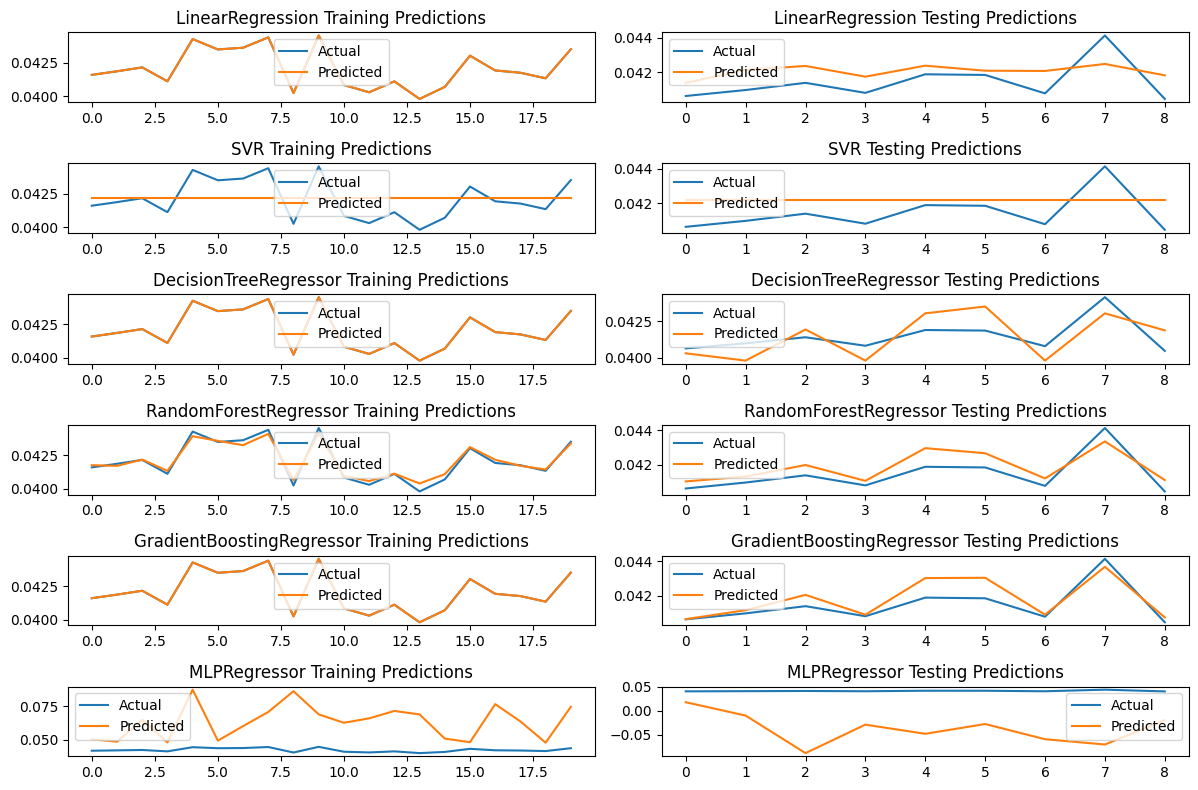

In [87]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(models), 2, figsize=(12, 8))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # 获取模型的预测值
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 绘制训练集预测值和实际值的图形
    axes[i, 0].plot(y_train.values, label='Actual')
    axes[i, 0].plot(y_pred_train, label='Predicted')
    axes[i, 0].set_title(f"{model_name} Training Predictions")
    axes[i, 0].legend()
    
    # 绘制测试集预测值和实际值的图形
    axes[i, 1].plot(y_test.values, label='Actual')
    axes[i, 1].plot(y_pred_test, label='Predicted')
    axes[i, 1].set_title(f"{model_name} Testing Predictions")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [82]:
window_size = 18  # 滑动窗口的大小
step_size = 1  # 步长

# 假设 X, y 是你的输入数据和目标值
n_samples = len(X)

for i in range(0, n_samples - window_size, step_size):
    X_window = X[i:i+window_size]
    y_window = y[i:i+window_size]

    # 拆分窗口数据为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_window, y_window, test_size=0.2, random_state=42)

    # 创建并训练模型
    model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    # 评估模型
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Window {i+1}-{i+window_size}:")
    print(f"Training R^2 Score: {train_score:.2f}")
    print(f"Testing R^2 Score: {test_score:.2f}")
    print("-----------------------")


Window 1-18:
Training R^2 Score: -233.01
Testing R^2 Score: -19358.40
-----------------------
Window 2-19:
Training R^2 Score: -193.75
Testing R^2 Score: -8179.16
-----------------------
Window 3-20:
Training R^2 Score: -684.48
Testing R^2 Score: -18046.50
-----------------------
Window 4-21:
Training R^2 Score: -188.04
Testing R^2 Score: -14514.77
-----------------------
Window 5-22:
Training R^2 Score: -525.05
Testing R^2 Score: -28546.04
-----------------------
Window 6-23:
Training R^2 Score: -840.02
Testing R^2 Score: -17422.56
-----------------------
Window 7-24:
Training R^2 Score: -1509.99
Testing R^2 Score: -33745.79
-----------------------
Window 8-25:
Training R^2 Score: -559.35
Testing R^2 Score: -72644.36
-----------------------
Window 9-26:
Training R^2 Score: -1314.17
Testing R^2 Score: -76836.70
-----------------------
Window 10-27:
Training R^2 Score: -640.95
Testing R^2 Score: -98538.27
-----------------------
Window 11-28:
Training R^2 Score: -1689.98
Testing R^2 Sco